In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
# Create data directory in Drive to persist across sessions
import os
DATA_DIR = '/content/drive/MyDrive/xai-stability-data'
os.makedirs(DATA_DIR, exist_ok=True)
print(f"Data will be saved to: {DATA_DIR}")

Data will be saved to: /content/drive/MyDrive/xai-stability-data


In [10]:
%cd /content
!git clone https://github.com/KamalasankariSubramaniakuppusamy/xai-stability-benchmark.git
%cd xai-stability-benchmark

/content
fatal: destination path 'xai-stability-benchmark' already exists and is not an empty directory.
/content/xai-stability-benchmark


In [11]:
# Install compatible numpy first
!pip install numpy==1.26.4

# Install other libraries
!pip install captum shap lime scikit-image scipy

print("All libraries installed with compatible numpy")

All libraries installed with compatible numpy


In [12]:
#Import Libraries
import torch
import torchvision
from torchvision import datasets, transforms, models
from captum.attr import IntegratedGradients, LayerGradCam, Saliency

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Check versions
print(f"PyTorch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.9.0+cu126
Torchvision version: 0.24.0+cu126
CUDA available: True


In [13]:
#Download CIFAR-10
print("Downloading CIFAR-10...")

# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Download to Drive (persists across sessions)
cifar_test = datasets.CIFAR10(
    root=f'{DATA_DIR}/cifar10',
    train=False,
    download=True,
    transform=transform
)

print(f"✓ CIFAR-10 downloaded: {len(cifar_test)} test images")

✓ CIFAR-10 downloaded: 10000 test images


In [14]:

# Load Pretrained Models ===
print("Loading pretrained models...")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ResNet-18 (for CIFAR-10 experiments)
resnet18 = models.resnet18(pretrained=True)
resnet18 = resnet18.to(device)
resnet18.eval()

# ResNet-50 (for ImageNet experiments later)
resnet50 = models.resnet50(pretrained=True)
resnet50 = resnet50.to(device)
resnet50.eval()

print("Models loaded:")
print(f" ResNet-18 on {device}")
print(f" ResNet-50 on {device}")

Loading pretrained models...
✓ Models loaded:
  - ResNet-18 on cuda
  - ResNet-50 on cuda


In [16]:

#Test on Single Image ===
print("\nTesting on sample image...")

# Get one image
image, label = cifar_test[0]
image_batch = image.unsqueeze(0).to(device)

# Run inference
with torch.no_grad():
    output = resnet18(image_batch)
    pred_class = output.argmax(dim=1).item()

print(f"Inference successful!")
print(f"  True label: {label} ({cifar_test.classes[label]})")
print(f"  Predicted: {pred_class} (confidence: {torch.softmax(output, dim=1).max().item():.3f})")


Testing on sample image...
Inference successful!
  True label: 3 (cat)
  Predicted: 118 (confidence: 0.044)


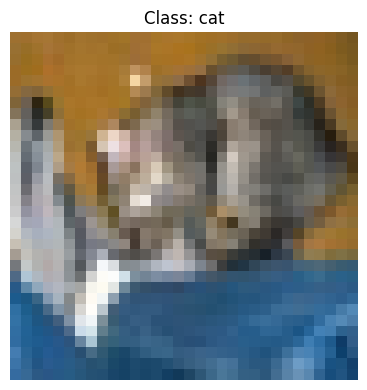

Sample image saved to figures/sample_image.png


In [19]:
# === CELL 8: Visualize Sample Image ===

import os
os.makedirs('figures', exist_ok=True)  # ← ADD THIS LINE

# Denormalize for visualization
def denormalize(tensor):
    tensor = tensor * 0.5 + 0.5  # Reverse normalization
    return tensor.clamp(0, 1)

plt.figure(figsize=(4, 4))
plt.imshow(denormalize(image).permute(1, 2, 0).cpu().numpy())
plt.title(f"Class: {cifar_test.classes[label]}")
plt.axis('off')
plt.tight_layout()
plt.savefig('figures/sample_image.png', dpi=150, bbox_inches='tight')
plt.show()

print("Sample image saved to figures/sample_image.png")

In [20]:
# Dataset Statistics
print("\n=== Dataset Statistics ===")
print(f"CIFAR-10 Test Set:")
print(f"  Total images: {len(cifar_test)}")
print(f"  Classes: {len(cifar_test.classes)}")
print(f"  Class names: {cifar_test.classes}")
print(f"  Image shape: {cifar_test[0][0].shape}")

# Check class distribution
labels = [cifar_test[i][1] for i in range(len(cifar_test))]
unique, counts = np.unique(labels, return_counts=True)
print(f"\nClass distribution (should be balanced):")
for cls, count in zip(unique, counts):
    print(f"  {cifar_test.classes[cls]}: {count} images")


=== Dataset Statistics ===
CIFAR-10 Test Set:
  Total images: 10000
  Classes: 10
  Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
  Image shape: torch.Size([3, 32, 32])

Class distribution (should be balanced):
  airplane: 1000 images
  automobile: 1000 images
  bird: 1000 images
  cat: 1000 images
  deer: 1000 images
  dog: 1000 images
  frog: 1000 images
  horse: 1000 images
  ship: 1000 images
  truck: 1000 images


In [21]:
# === CELL 10: Quick XAI Test ===
print("\n=== Testing XAI Methods ===")

# Test Integrated Gradients
ig = IntegratedGradients(resnet18)
attributions_ig = ig.attribute(image_batch, target=pred_class)

print(f"Integrated Gradients works! Attribution shape: {attributions_ig.shape}")

# Test GradCAM (need to specify layer)
layer_gc = LayerGradCam(resnet18, resnet18.layer4[-1])
attributions_gc = layer_gc.attribute(image_batch, target=pred_class)

print(f"GradCAM works! Attribution shape: {attributions_gc.shape}")


=== Testing XAI Methods ===
Integrated Gradients works! Attribution shape: torch.Size([1, 3, 32, 32])
GradCAM works! Attribution shape: torch.Size([1, 1, 1, 1])


In [22]:
# CELL 11: Save Configuration
config = {
    'dataset': 'CIFAR-10',
    'num_test_images': len(cifar_test),
    'models': ['ResNet-18', 'ResNet-50'],
    'device': str(device),
    'data_dir': DATA_DIR,
    'status': 'Setup complete'
}

import json
os.makedirs('results', exist_ok=True)
with open('results/setup_config.json', 'w') as f:
    json.dump(config, f, indent=2)

print("\Configuration saved to results/setup_config.json")

\Configuration saved to results/setup_config.json


<>:16: SyntaxWarning: invalid escape sequence '\C'
<>:16: SyntaxWarning: invalid escape sequence '\C'
/tmp/ipython-input-2544483108.py:16: SyntaxWarning: invalid escape sequence '\C'
  print("\Configuration saved to results/setup_config.json")


In [23]:
#CELL 12: Summary
print("\n" + "="*50)
print("SETUP COMPLETE!")
print("="*50)
print("\nWhat's ready:")
print("  Libraries installed (Captum, SHAP, LIME)")
print("  CIFAR-10 dataset downloaded")
print("  Pretrained models loaded (ResNet-18, ResNet-50)")
print("  XAI methods tested")
print("  Sample visualizations created")
print("\nNext steps:")
print("  Open notebook 02_perturbations.ipynb")
print("  Implement perturbation functions")
print("="*50)


SETUP COMPLETE!

What's ready:
  Libraries installed (Captum, SHAP, LIME)
  CIFAR-10 dataset downloaded
  Pretrained models loaded (ResNet-18, ResNet-50)
  XAI methods tested
  Sample visualizations created

Next steps:
  Open notebook 02_perturbations.ipynb
  Implement perturbation functions
